# Basic Concepts

This tutorial is an introduction to medicinal chemistry molecular filtering. It will show that applying thoes type of filters and rules systematically and blindly is often not a good idea. While powerful such filtering technics must always be carefully assesed and prototyped before using systematically and at large scale.


In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from rdkit.Chem import PandasTools
import datamol as dm
import pandas as pd

import medchem as mc


## Marketed drugs does not always pass medchem filters

_NOTE(hadim): show that some drugs pass and some other does not pass the filters. It's important to consider the whole pipeline. At early stage, filters and rules might make sense and during LO and further, small critical modifications will make the drug to fail on certain filters that used to work before_


In [70]:
data = dm.data.chembl_drugs()

data["mol"] = data["smiles"].apply(dm.to_mol)

# Apply basic rules
data["rule_of_five"] = data["smiles"].apply(mc.rules.basic_rules.rule_of_five)
data["rule_of_ghose"] = data["smiles"].apply(mc.rules.basic_rules.rule_of_ghose)
data["rule_of_veber"] = data["smiles"].apply(mc.rules.basic_rules.rule_of_veber)
data["rule_of_zinc"] = data["smiles"].apply(mc.rules.basic_rules.rule_of_zinc)

# Apply some default medchem filters
data["alerts_BMS"] = mc.functional.alert_filter(
    mols=data["mol"].tolist(),
    alerts=["BMS"],
    n_jobs=-1,
    progress=True,
    return_idx=False,
)
data["alerts_PAINS"] = mc.functional.alert_filter(
    mols=data["mol"].tolist(),
    alerts=["PAINS"],
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["alerts_SureChEMBL"] = mc.functional.alert_filter(
    mols=data["mol"].tolist(),
    alerts=["SureChEMBL"],
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filters_NIBR"] = mc.functional.nibr_filter(
    mols=data["mol"].tolist(),
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filter_complexity"] = mc.functional.complexity_filter(
    mols=data["mol"].tolist(),
    complexity_metric="bertz",
    threshold_stats_file="zinc_15_available",
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filter_bredt"] = mc.functional.bredt_filter(
    mols=data["mol"].tolist(),
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filter_molecular_graph"] = mc.functional.molecular_graph_filter(
    mols=data["mol"].tolist(),
    max_severity=5,
    n_jobs=-1,
    progress=True,
    return_idx=False,
)

data["filter_lilly_demerit"] = mc.functional.lilly_demerit_filter(
    mols=data["mol"].tolist(),
    n_jobs=-1,
    progress=True,
    return_idx=False,
)


Common alerts filtering:   0%|          | 0/1935 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/1935 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/1935 [00:00<?, ?it/s]

NIBR filtering:   0%|          | 0/1935 [00:00<?, ?it/s]

Complexity Evaluation:   0%|          | 0/1935 [00:00<?, ?it/s]

To mol:   0%|          | 0/1935 [00:00<?, ?it/s]

Filtering with catalogs:   0%|          | 0/19 [00:00<?, ?it/s]

Match:   0%|          | 0/1935 [00:00<?, ?it/s]

In [74]:
filter_columns = [
    "rule_of_five",
    "rule_of_ghose",
    "rule_of_veber",
    "rule_of_zinc",
    "alerts_BMS",
    "alerts_PAINS",
    "alerts_SureChEMBL",
    "filters_NIBR",
    "filter_complexity",
    "filter_bredt",
    "filter_molecular_graph",
    "filter_lilly_demerit",
]


f, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

cmap = matplotlib.colors.ListedColormap(["#EF6262", "#1D5B79"], None)

sns.heatmap(
    data[filter_columns].T,
    annot=False,
    ax=ax,
    xticklabels=False,  # type: ignore
    yticklabels=True,  # type: ignore
    cbar=True,
    cmap=cmap,
)
# sns.heatmap(data[filter_columns], annot=False, ax=ax, xticklabels=False, yticklabels=False)

ax.collections[0].colorbar.set_ticks([0.25, 0.75])
ax.collections[0].colorbar.set_ticklabels([False, True], fontsize=14)

ax.set_xlabel(f"Drug Molecules (n={len(data)})", fontsize=18)
_ = ax.set_ylabel("Medchem Filters", fontsize=18)


## New drugs versus old drugs

_NOTE(hadim): shows new drugs less likely to pass common filters (cite a paper if possible)_


## Case study: pro-drugs

Some drugs are designed as [prodrug](https://en.wikipedia.org/wiki/Prodrug) that will be only be made active once in the human body after being metabolized. Those compounds will tend to have unwanted molecular features that are often flagged by common alerts and rules.

Below we load a small dataset of 7 drug/prodrug pairs and apply some common medchem rules on them.

,Drug,Drug mol,Prodrug,Prodrug mol,rule_of_five,rule_of_ghose,rule_of_veber,rule_of_zinc
0,Gabapentin,,Gabapentin enacarbil,,Ro5Drug: TrueProdrug: True,GhoseDrug: FalseProdrug: True,VeberDrug: TrueProdrug: True,ZincDrug: TrueProdrug: True
1,Dabigatran,,Dabigatran etexilate,,Ro5Drug: TrueProdrug: False,GhoseDrug: FalseProdrug: False,VeberDrug: FalseProdrug: False,ZincDrug: FalseProdrug: False
2,Sofosbuvir,,Sofosbuvir,,Ro5Drug: TrueProdrug: False,GhoseDrug: FalseProdrug: False,VeberDrug: FalseProdrug: False,ZincDrug: FalseProdrug: False
3,Tedizolid,,Tedizolid phosphate,,Ro5Drug: TrueProdrug: False,GhoseDrug: TrueProdrug: True,VeberDrug: TrueProdrug: False,ZincDrug: TrueProdrug: False
4,Isavuconazole,,Isavuconazonium,,Ro5Drug: TrueProdrug: False,GhoseDrug: TrueProdrug: False,VeberDrug: TrueProdrug: False,ZincDrug: TrueProdrug: False
5,Aripiprazole,,Aripiprazole lauroxil,,Ro5Drug: TrueProdrug: False,GhoseDrug: TrueProdrug: False,VeberDrug: TrueProdrug: False,ZincDrug: TrueProdrug: False
6,ACT-333679,,Selexipag,,Ro5Drug: TrueProdrug: True,GhoseDrug: TrueProdrug: False,VeberDrug: FalseProdrug: False,ZincDrug: TrueProdrug: True

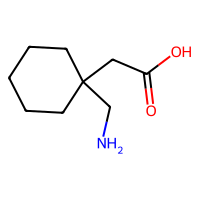
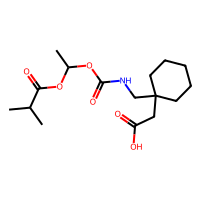
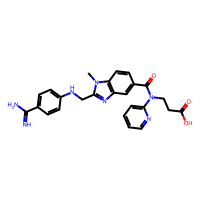
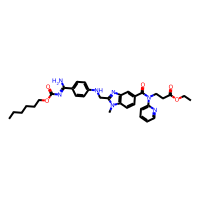
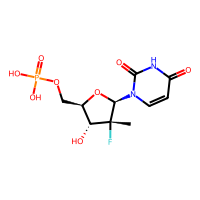
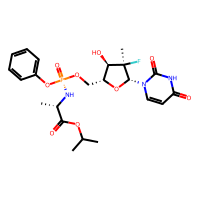
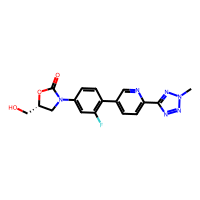
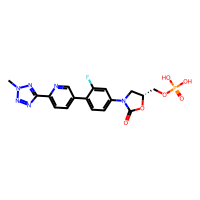
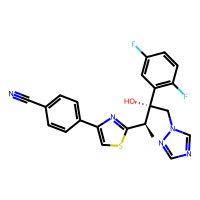
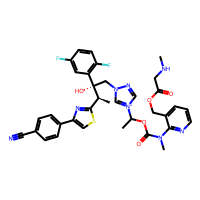
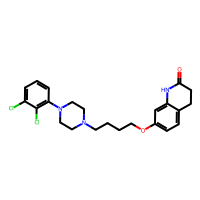
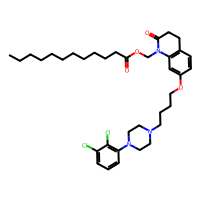
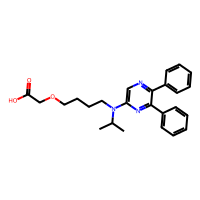
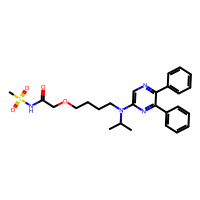

In [69]:
# Load the dataset
data = pd.read_csv("./data/Drug_Prodrug_pairs.csv")

# Compute mol objects
data["Drug mol"] = data["Drug SMILES"].apply(dm.to_mol)
data["Prodrug mol"] = data["Prodrug SMILES"].apply(dm.to_mol)

# Reorder the columns
data = data[["Drug", "Drug mol", "Prodrug", "Prodrug mol"]]


# Apply a few medchem rules to the drugs and prodrugs
def _apply_rules(row):
    rule_names = [
        ("Ro5", "rule_of_five"),
        ("Ghose", "rule_of_ghose"),
        ("Veber", "rule_of_veber"),
        ("Zinc", "rule_of_zinc"),
    ]

    for rule_label, rule_name in rule_names:
        rule_fn = getattr(mc.rules.basic_rules, rule_name)

        # Apply the rule to the drug and prodrug
        drug_ok = rule_fn(dm.copy_mol(row["Drug mol"]))
        prodrug_ok = rule_fn(dm.copy_mol(row["Prodrug mol"]))

        row[rule_name] = f"{rule_label}\nDrug: {drug_ok}\nProdrug: {prodrug_ok}"

    return row


data = data.apply(_apply_rules, axis=1)

# Enable drawing in the dataframe
PandasTools.ChangeMoleculeRendering(data)

# Small hack to display new lines as well as RDKit drawings
HTML(data.to_html().replace("\\n", "<br>"))


While this is not systematic, we observe that many drugs passes the rules while the associated prodrugs does not pass them.

---

-- The End :-)